In [1]:
# Load necessary packages
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from jax.random import uniform, PRNGKey

# User-defined
from ANN_1DOF import Damped_MLP, Damped_LNN
from helpers import train_test_data, generate_data

from jax import config
config.update("jax_enable_x64", True)

#### Generate Training Data

In [2]:
# Generate continuation data
old_train_dataset, old_test_dataset, info = train_test_data(
    save_file='data/data.pkl', 
    split_size=0.1, 
    file_name='contparameters.json', 
    min_force_amp=0.1, 
    max_force_amp=1.0, 
    step=0.1, 
    phase_ratio=0.5, 
    damping=0.05
)



Iter Cont     Iter Corr     Residual      Freq          Energy        Step          Beta          
0             0             1.2826e-01    0.0955        5.0861e-02                                
0             1             4.2430e-03    0.0955        1.9854e-02                                
0             2             9.4199e-07    0.0955        1.9376e-02                                
1             0             8.2709e-07    0.0955        1.9391e-02    -5.000e-03                  
1             1             1.9545e-13    0.0955        1.9392e-02    -5.000e-03    0.0022        
--------------------------------------------------------------------------------------------------
2             0             5.4762e-07    0.0956        1.9423e-02    -1.000e-02                  
2             1             1.2469e-13    0.0956        1.9423e-02    -1.000e-02    0.0039        
--------------------------------------------------------------------------------------------------
3       

/home/aax23/.conda/envs/.duffing/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/aax23/PyCont_release/core/solver/_psacont.py:104: LinAlgWarning: Ill-conditioned matrix (rcond=3.85971e-255): result may not be accurate.
  dxt = spl.solve(Jcr, -Z, check_finite=False)


91            3             7.8531e-02    0.2969        5.1836e+00    -5.000e-02                  
91            4             3.4761e-02    0.3151        6.7238e+00    -5.000e-02                  
91            0             3.8241e-03    0.3214        7.1801e+00    -2.500e-02                  
91            1             3.4493e-03    0.3288        7.8711e+00    -2.500e-02                  
91            2             1.8020e-01    0.4238        2.3305e+01    -2.500e-02                  
91            3             2.2584e+01    0.1379        3.8606e+02    -2.500e-02                  
91            4             1.1693e+01    0.1426        5.1488e+02    -2.500e-02                  
91            0             1.9433e-03    0.3213        7.1699e+00    -1.250e-02                  
91            1             8.5308e-04    0.3251        7.5149e+00    -1.250e-02                  
91            2             6.1895e-04    0.3285        7.8361e+00    -1.250e-02                  
91        

In [3]:
info

{'delta': 0.05,
 'alpha': 1.0,
 'beta': 1.0,
 'M': 1.0,
 'K': 1.0,
 'C': 0.05,
 'NL': 1.0,
 'train_n_datapoints': 505710,
 'test_n_datapoints': 58063,
 'qmax': 3.321380986914027,
 'qdmax': 8.898046808018155,
 'qddmax': 43.5745696095665,
 't': 9.688802965767703,
 'fmax': 1.0}

#### Format Dataset for LNN Code

In [4]:
old_train_dataset.keys()

dict_keys(['x', 'dx', 'ddx', 't', 'f'])

In [5]:
old_train_dataset['x'].shape, old_train_dataset['dx'].shape, old_train_dataset['ddx'].shape, old_train_dataset['t'].shape, old_train_dataset['f'].shape

((270, 1873), (270, 1873), (270, 1873), (270, 1873), (270, 1873))

In [6]:
old_train_dataset['x'].flatten(), old_train_dataset['dx'].flatten()

(array([-1.99355066, -1.98911582, -1.98411001, ..., -0.44050742,
        -0.41675103, -0.39306843]),
 array([-7.42389259, -7.5433142 , -7.6635054 , ..., -6.99041884,
        -6.99756991, -7.00396685]))

In [7]:
train_x = np.vstack((old_train_dataset['x'].flatten(), old_train_dataset['dx'].flatten())).T
train_f = old_train_dataset['f'].flatten()
train_dx = np.vstack((old_train_dataset['dx'].flatten(), old_train_dataset['ddx'].flatten())).T

test_x = np.vstack((old_test_dataset['x'].flatten(), old_test_dataset['dx'].flatten())).T
test_f = old_test_dataset['f'].flatten()
test_dx = np.vstack((old_test_dataset['dx'].flatten(), old_test_dataset['ddx'].flatten())).T

train_dataset = train_x, train_f, train_dx
test_dataset = test_x, test_f, test_dx

#### LNN Training

In [8]:
settings = {
    'name': 'ANN_LNN_Damped_Test',
    'lag_units': 64,
    'damp_units': 16,
    'layers': 3,
    'input_shape': 2,
    'train_batch_size': 128,
    'test_batch_size': 64,
    'shuffle': True,
    'seed': 0
    }

phy_sys = {
    'M': info['M'],
    'K': info['K'],
    'C': info['C'],
    'NL': info['NL'],
}

lr = 1e-03
optimizer = optax.adam(lr)
a = Damped_LNN(Damped_MLP, optimizer, settings, info, phy_sys)
a.gather()

True

In [9]:
# Load previous results, if any
# prev_results = a.load_model('results/ANN_Damped_100epochs/model.pkl')

In [10]:
# Start training LNN
results = a.train(train_dataset, test_dataset, results=None, epochs=100, show_every=10)

Epoch: 0 | Train Loss: 36.71985533 | Best Loss: 1.45969162 | Test Loss: 1.45969162
--------------------------------------------------------------------------------------------------------
Epoch: 10 | Train Loss: 0.00000826 | Best Loss: 0.00001988 | Test Loss: 0.00001988
--------------------------------------------------------------------------------------------------------
Epoch: 20 | Train Loss: 0.00000500 | Best Loss: 0.00001325 | Test Loss: 0.00001770
--------------------------------------------------------------------------------------------------------
Epoch: 30 | Train Loss: 0.00000309 | Best Loss: 0.00000385 | Test Loss: 0.00002135
--------------------------------------------------------------------------------------------------------
Epoch: 40 | Train Loss: 0.00000304 | Best Loss: 0.00000222 | Test Loss: 0.00000759
--------------------------------------------------------------------------------------------------------
Epoch: 50 | Train Loss: 0.00000251 | Best Loss: 0.00000171 |

In [11]:
# Save results
a.save_model(results, 'results/ANN_Damped_100epochs')

('results/ANN_Damped_100epochs/model.pkl',
 'results/ANN_Damped_100epochs/metrics.pkl')

#### Examine Data Scope

In [12]:
import pickle
with open('./data/data.pkl', 'rb') as f:
   data = pickle.load(f)

In [13]:
# Store ML data
x = np.array([])
dx = np.array([])
ddx = np.array([])
t = np.array([])
f = np.array([])
period = np.array([])

# Loop over data
for k, v in data.items():
    pose = data[k]["pose"]
    vel = data[k]["vel"]
    acc = data[k]["acc"]
    time = data[k]["time"]
    force = data[k]["force"]
    T = data[k]["T"]
        
    x = np.append(x, pose)
    dx = np.append(dx, vel)
    ddx = np.append(ddx, acc)
    t = np.append(t, time)
    f = np.append(f, force)
    period = np.append(period, T)

Text(0.5, 0, '$\\ddot{x}$')

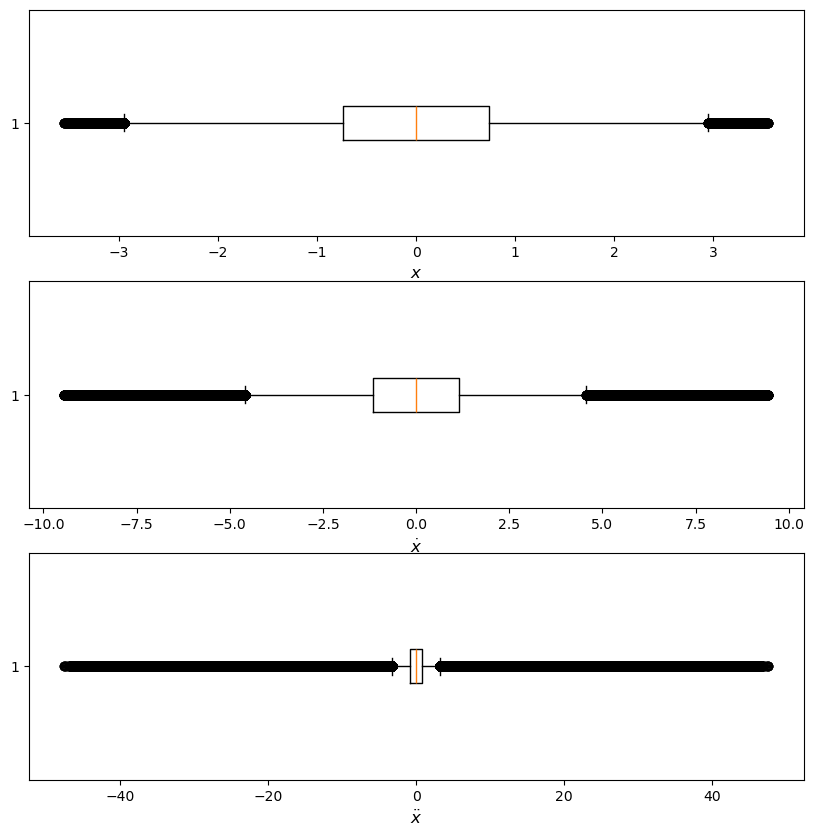

In [14]:
# Plot figures
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Plot Displacement, Velocity and Acceleration
ax[0].boxplot(x, vert=0)
ax[0].set_xlabel(r'$x$', fontsize=12)

ax[1].boxplot(dx, vert=0)
ax[1].set_xlabel(r'$\dot{x}$', fontsize=12)

ax[2].boxplot(ddx, vert=0)
ax[2].set_xlabel(r'$\ddot{x}$', fontsize=12)

### Examine results

In [15]:
# Plotting the corresponding lagrangian and damping function for each output in the test dataset
pred_acc_damped, pred_energy_damped = a._predict(results)
q, q_d = jnp.split(test_dataset[0], 2, axis=-1)
n = 301
Lnn, Dnn = pred_energy_damped(q, q_d)

In [16]:
# Comparing accelerations
F = test_dataset[1].reshape(q.shape[0], -1)
q_dd = pred_acc_damped(test_dataset[0], F)[:, -1]

In [17]:
lim1, lim2 = info['qmax'], info['qdmax']

qa, qda = jnp.linspace(-lim1, lim1, 100), jnp.linspace(-lim2, lim2, 100)
qaa, qdaa = jnp.meshgrid(qa, qda)

# Get all energy functions here
L, D = jax.vmap(pred_energy_damped)(qaa.reshape(-1,1,1), qdaa.reshape(-1,1,1))
Lagrange_analy = 0.5*phy_sys['M']*qdaa**2 - 0.5*phy_sys['K']*qaa**2 - 0.25*phy_sys['NL']*qaa**4
Dissipation_analy = 0.5*phy_sys['C']*qdaa**2

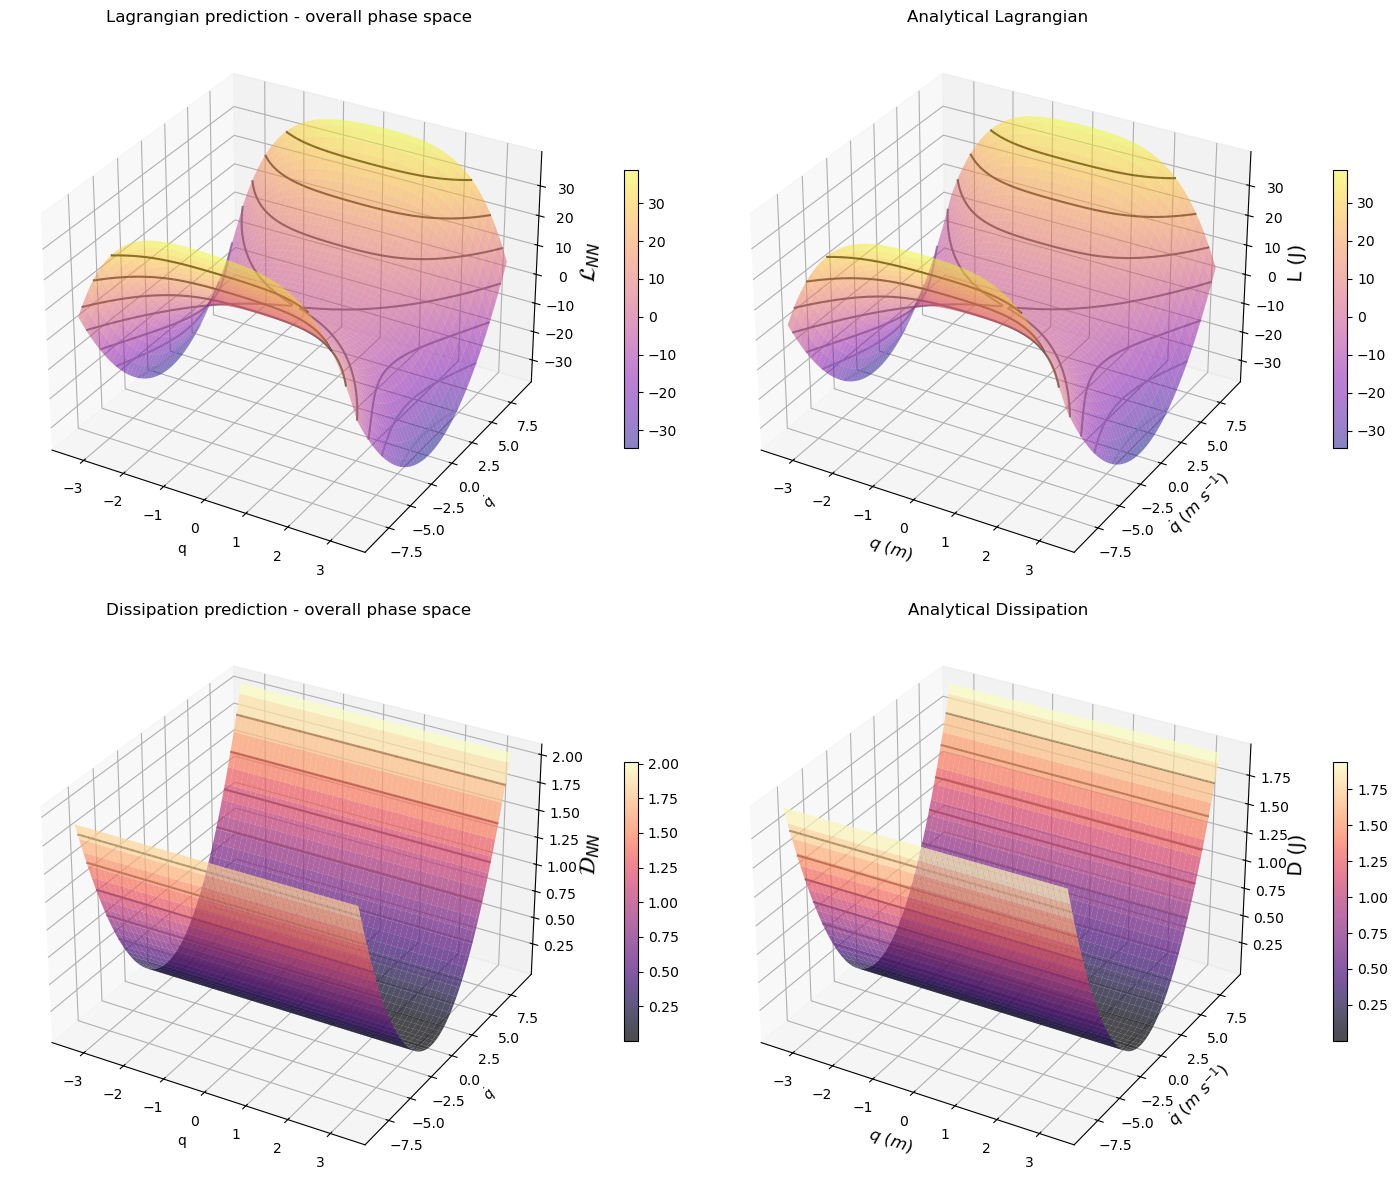

In [18]:
fig = plt.figure(figsize=(15,12), tight_layout=True)

ax = fig.add_subplot(221, projection='3d')
m = ax.plot_surface(qaa, qdaa, L.reshape(qaa.shape), alpha=0.5, cmap='plasma')
ax.contour3D(qaa, qdaa, L.reshape(qaa.shape), cmap='binary')
ax.set_xlabel('q')
ax.set_ylabel(r'$\dot{q}$')
ax.set_zlabel(r'$\mathcal{L}_{NN}$', fontsize=16, labelpad=3)
ax.set_title('Lagrangian prediction - overall phase space')
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(222, projection = '3d')
m = ax.plot_surface(qaa, qdaa, Lagrange_analy.reshape(qaa.shape), alpha=0.5, cmap='plasma')
ax.contour3D(qaa, qdaa, Lagrange_analy.reshape(qaa.shape), cmap='binary')
ax.set_title('Analytical Lagrangian')
ax.set_xlabel(r'$q \ (m)$', fontsize=12)
ax.set_ylabel(r'$\dot{q} \ (m \ s^{-1})$ ', fontsize=12)
ax.set_zlabel(r'L (J)', fontsize=14, labelpad=2)
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(223, projection='3d')
m = ax.plot_surface(qaa, qdaa, D.reshape(qaa.shape), alpha=0.7, cmap='magma')
ax.contour3D(qaa, qdaa, D.reshape(qaa.shape), cmap='binary')
ax.set_xlabel('q')
ax.set_ylabel(r'$\dot{q}$')
ax.set_zlabel(r'$\mathcal{D}_{NN}$', fontsize=16, labelpad=3)
ax.set_title('Dissipation prediction - overall phase space')
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)

ax = fig.add_subplot(224, projection = '3d')
m = ax.plot_surface(qaa, qdaa, Dissipation_analy.reshape(qaa.shape), alpha=0.7, cmap='magma')
ax.contour3D(qaa, qdaa, Dissipation_analy.reshape(qaa.shape), cmap='binary')
ax.set_title('Analytical Dissipation')
ax.set_xlabel(r'$q \ (m)$', fontsize=12)
ax.set_ylabel(r'$\dot{q} \ (m \ s^{-1})$ ', fontsize=12)
ax.set_zlabel(r'D (J)', fontsize=14, labelpad=2)
fig.colorbar(m, ax=ax,shrink=0.5, pad=0.075)